# Planets Model

## Load Libs


In [ ]:
import ast
import os
import re

import icecream
import jax.numpy as jnp
import numpy as np
import pandas as pd
import torch

# Add these imports
from icecream import ic
from torch.utils.data import DataLoader

# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange
from transformers import BertTokenizerFast, FlaxBertModel

import hephaestus as hp
from hephaestus.models import TimeSeriesDecoder

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = False  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

We use BERT tokenizer to tokenize the text data.


In [3]:
model_name = "bert-base-uncased"
model = FlaxBertModel.from_pretrained(model_name, add_pooling_layer=False)
tokenizer = BertTokenizerFast.from_pretrained(model_name)
batch_size = 16

## Load Data

We use `line2df` to load the original data from
[PolyMathic](https://polymathic-ai.org/blog/xval/). Since we've already transformed the
data into a parquet file, we can load it directly.


In [ ]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [4]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [5]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [6]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['3_planets',
 'increasing',
 '5_planets',
 '2_planets',
 'decreasing',
 '4_planets']

In [7]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [ ]:
df = df.reset_index(drop=True)
df = df.head(
    5_000
)  # For testing purposes only, train on the full dataset in production

In [9]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [ ]:
N_HEADS = 8 * 4
tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [ ]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

In [ ]:
batch = train_ds[0:6]
res = tabular_decoder(
    numeric_inputs=batch["numeric"],
    categorical_inputs=batch["categorical"],
    deterministic=False,
)

In [ ]:
res.numeric.shape, res.categorical.shape

((4, 27, 59), (4, 3, 59, 41))

In [ ]:
ic.disable()

: 

In [ ]:
# Create DataLoader for more efficient batch processing
# TODO Add collate_fn to a separate file


def collate_fn(batch):
    numeric = []
    categorical = []
    for item in batch:
        numeric.append(item.numeric)
        categorical.append(item.categorical)

    return {
        "numeric": torch.tensor(np.array(numeric), dtype=torch.float32),
        "categorical": torch.tensor(np.array(categorical), dtype=torch.float32),
    }

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,
)
tabular_decoder = tabular_decoder.to(device)  # Move model to device first

# Create a sample batch from the training dataset
example_batch = train_ds[0:6]
numeric_data = example_batch.numeric.to(device)
categorical_data = example_batch.categorical.to(device)
# Before making a prediction, do a sanity check on inputs
print("Input shapes:", numeric_data.shape, categorical_data.shape)
print("Input contains NaN (numeric):", torch.isnan(numeric_data).any().item())
print("Input contains NaN (categorical):", torch.isnan(categorical_data).any().item())

In [ ]:
with torch.no_grad():
    prediction = tabular_decoder(numeric_data, categorical_data)

    # Move predictions back to CPU for numpy operations if needed
    prediction = prediction.to("cpu")

    prediction.numeric = prediction.numeric.transpose(1, 2)
    prediction.categorical = prediction.categorical.permute(0, 2, 1, 3)


# Print prediction summary instead of all values
print("Prediction numeric shape:", prediction.numeric.shape)
print("Prediction categorical shape:", prediction.categorical.shape)
print(
    "Prediction contains NaN (numeric):",
    torch.isnan(prediction.numeric).any().item(),
)
print(
    "Prediction contains NaN (categorical):",
    torch.isnan(prediction.categorical).any().item(),
)

In [ ]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [ ]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].head()

,n_planets,acceleration_x,acceleration_y
0,33,34,34
1,33,34,34
2,33,34,34
3,33,34,34
4,33,34,34


In [ ]:
df_comp.output_df.loc[:, time_series_config.numeric_col_tokens].head()

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
0,-0.086939,1.623931,-0.723367,0.414234,0.909256,0.480775,2.877100,1.240049,1.811669,1.838325,...,0.411454,2.684227,2.004413,1.021967,0.258596,0.562351,2.202389,1.700102,1.599445,6.882668
1,0.743516,1.727718,0.016551,-0.061823,1.118379,0.318351,2.865866,1.364011,1.828208,1.808961,...,0.560357,2.547730,1.896158,1.022707,0.254310,0.363497,1.859695,1.638075,1.707799,6.654531
2,1.574918,1.798751,0.304389,-0.623722,0.896999,-0.089107,2.746975,1.157834,1.691595,1.774458,...,0.521108,2.452365,1.913805,1.043840,0.105787,0.284898,1.759382,1.515778,1.617503,6.497258
3,1.811152,1.587842,0.670688,-0.828452,0.470470,-0.287538,2.890650,1.204766,1.679821,1.849562,...,0.680307,2.525071,1.802918,0.964938,0.030930,0.200680,2.073874,1.645826,1.531525,6.630600
4,2.212927,1.379405,0.993599,-0.878572,0.098262,-0.586159,2.624851,1.319260,1.671490,1.720907,...,0.545571,2.449077,1.829996,1.029940,0.111952,0.169566,1.977852,1.616984,1.545752,6.899182


In [ ]:
test_inputs = hp.AutoRegressiveResults.from_ds(train_ds, 0, 13)


for i in trange(21):
    test_inputs = hp.auto_regressive_predictions(tabular_decoder, test_inputs)

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
auto_df = hp.create_test_inputs_df(test_inputs, time_series_config)

In [ ]:
auto_df.head(20)

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,34.0,34.0
1,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,34.0,34.0
2,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,34.0,34.0
3,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,34.0,34.0
4,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,34.0,34.0
5,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,34.0,34.0
6,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674529,2.825381,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,32.0,34.0
7,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,32.0,34.0
8,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,32.0,34.0
9,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,33.0,32.0,34.0


In [ ]:
res1 = tabular_decoder(
    numeric_inputs=jnp.array([train_ds[0][0][:, :10]]),
    categorical_inputs=jnp.array([train_ds[0][1][:, :10]]),
)


res_df = hp.create_non_auto_df(res1, time_series_config)
actual_df = hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

In [ ]:
hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

,n_planets,acceleration_x,acceleration_y,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
0,33.0,34.0,34.0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
1,33.0,34.0,34.0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
2,33.0,34.0,34.0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
3,33.0,34.0,34.0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
4,33.0,34.0,34.0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
5,33.0,34.0,34.0,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
6,33.0,32.0,34.0,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674529,2.825381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
7,33.0,32.0,34.0,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
8,33.0,32.0,34.0,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
9,33.0,32.0,34.0,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123


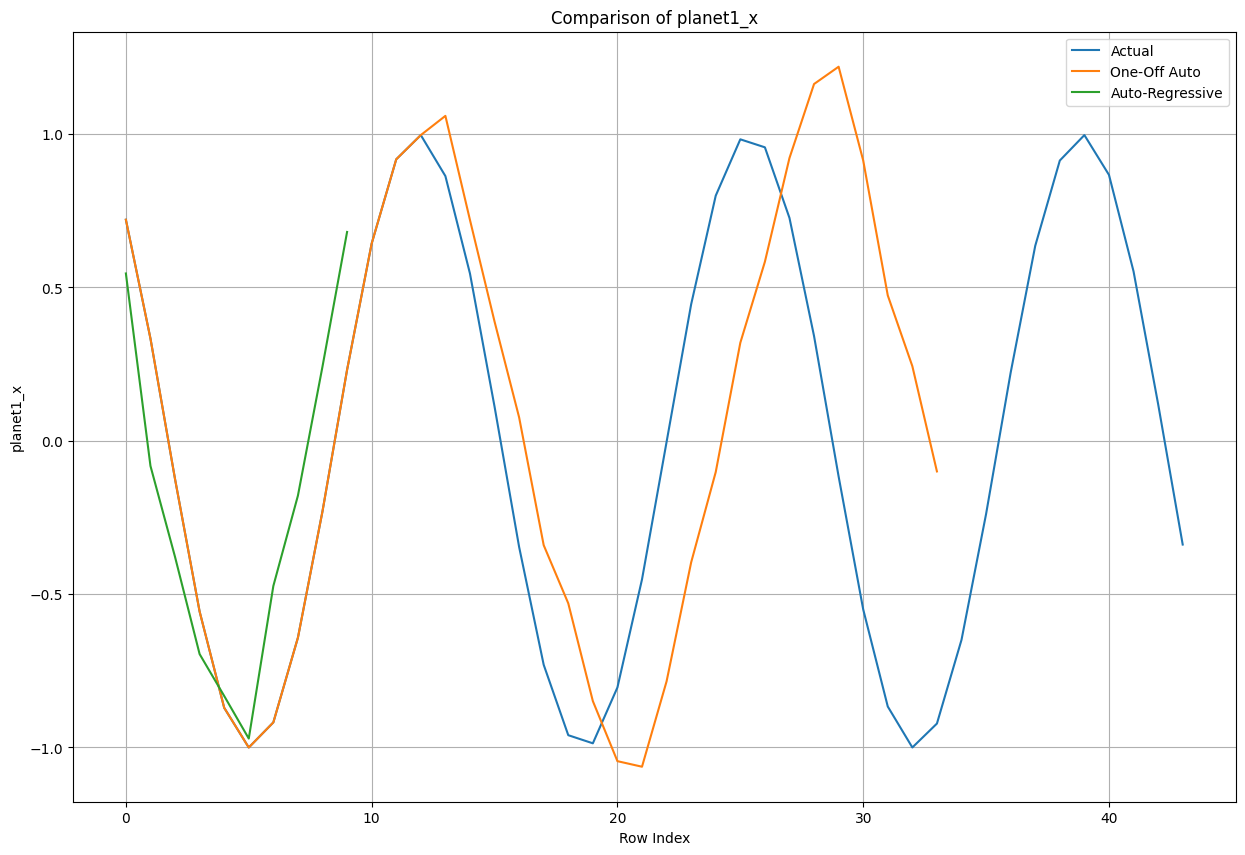

In [ ]:
hp.plot_comparison(actual_df, auto_df, res_df, "planet1_x")